# Skin Cancer Image Processing with Pre-Trained Models

In this notebook, pre-trained VGG16 model will be used to classify skin lesion images. I will iterate over this model by adding various dense layers after the pre-trained layers to find optimal model that has better accuracy and recall scores than the CNN models done in the [Image_Processing_and_Modeling](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Image_Processing_and_Modeling.ipynb) notebook.   

In [1]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

# importing pre-trained networks
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

In [2]:
# Define modeling results display function:
def visualize_modeling_results(results):
    '''   
    Input: model history results
    '''
    history = results.history
    
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower left')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## 1. Data Preperation

In [3]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET_512x512.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12431,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12432,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12433,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12434,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg


In [4]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [5]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       4845
malignant    4108
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
2034,ISIC_0714807,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,20.0,upper extremity,benign
6216,ISIC_1984995,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,30.0,palms/soles,benign
1848,ISIC_0663588,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,torso,benign
11624,ISIC_0071693,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,40.0,head/neck,malignant
4775,ISIC_1558731,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,torso,benign
...,...,...,...,...,...,...
2578,ISIC_0884397,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,torso,benign
11825,ISIC_0072990,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,anterior torso,malignant
672,ISIC_0307958,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,palms/soles,benign
6213,ISIC_1984152,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign


In [8]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Test dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Test dataset: 
 benign       1211
malignant    1028
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
8227,ISIC_0028219,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,45.0,upper extremity,malignant
3879,ISIC_1289942,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,torso,benign
2819,ISIC_0954236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
11196,ISIC_0068438,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,75.0,palms/soles,malignant
1808,ISIC_0652205,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,lower extremity,benign
...,...,...,...,...,...,...
10278,ISIC_0062029,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,80.0,anterior torso,malignant
5484,ISIC_1768051,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,70.0,lower extremity,benign
4342,ISIC_1431236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign
3993,ISIC_1326366,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,lower extremity,benign


In [9]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       694
malignant    550
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10405,ISIC_0062914,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,lower extremity,malignant
6392,ISIC_2038024,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
1483,ISIC_0552960,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,lower extremity,benign
4190,ISIC_1384527,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,lower extremity,benign
8635,ISIC_0032724,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,posterior torso,malignant
...,...,...,...,...,...,...
8450,ISIC_0030929,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,55.0,upper extremity,malignant
4949,ISIC_1611285,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,30.0,lower extremity,benign
2239,ISIC_0772957,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
10402,ISIC_0062891,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,35.0,anterior torso,malignant


## 2. Image Preprocessing

In [10]:
# Instantiating a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Creating the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_train),
                                                seed=42,
                                                class_mode='binary')


# Creating the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 64x64
                                              target_size=(64, 64),
                                              batch_size=len(df_val),
                                              seed=42,
                                              class_mode='binary')


# Setting aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_test),
                                                seed=42,
                                                class_mode='binary')

Found 8953 validated image filenames belonging to 2 classes.
Found 2239 validated image filenames belonging to 2 classes.
Found 1244 validated image filenames belonging to 2 classes.


In [11]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [12]:
# Create image and labels data sets by using next() fnc, it returns next item in the generator above:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [13]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


In [14]:
# Explore dataset again
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of test samples: " + str(m_test))

print ("train_images shape: " + str(train_images.shape))   
print ("train_labels shape: " + str(train_labels.shape))

print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 8953
Number of validation samples: 2239
Number of test samples: 1244
train_images shape: (8953, 64, 64, 3)
train_labels shape: (8953,)
val_images shape: (2239, 64, 64, 3)
val_labels shape: (2239,)
test_images shape: (1244, 64, 64, 3)
test_labels shape: (1244,)


In [24]:
# Reshaping image sets:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(8953, 12288)
(2239, 12288)
(1244, 12288)


## 3. Modeling with Pre-Trained Models

## 3.1. VGG-16 Model

### First iteration 

In [25]:
# Defined pretrained VGG-16 model:
vgg16 = VGG16(weights='imagenet',
               include_top=False,
               input_shape=(64, 64, 3))

In [26]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [34]:
# Define early stop criteria for model:
early_stop1 = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
    ModelCheckpoint(filepath='../Saved_Models/model1_vgg16_best_model.h5', monitor='val_accuracy', 
                    mode='max', save_best_only=True, verbose=1)]


In [35]:
# Create architecture of the model:
model1_vgg16 = models.Sequential()
model1_vgg16.add(vgg16)

# adding dense layers from CNN iterations final model:
model1_vgg16.add(layers.Flatten())
model1_vgg16.add(layers.Dense(128, activation='relu'))
model1_vgg16.add(layers.Dense(64, activation='relu'))
model1_vgg16.add(layers.Dense(32, activation='relu'))
model1_vgg16.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model1_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 14,987,329
Trainable params: 272,641
Non-trainable params: 14,714,688
____________________________________

In [37]:
# Make sure that the pretrianed layer is untrainable
# We don't want to change the weights durinf optimization
vgg16.trainable = False

In [38]:
# Print out the layers' trainability condition:
for layer in model1_vgg16.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_2 True
dense_6 True
dense_7 True
dense_8 True
dense_9 True


In [39]:
# Compile and fit the model:
model1_vgg16.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

model1_vgg16_history = model1_vgg16.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    callbacks = early_stop,
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.7930 - recall: 0.7020 - precision: 0.8210 - auc: 0.8620
Epoch 00001: val_accuracy improved from 0.81867 to 0.82180, saving model to ../Saved_Models\vgg16_best_model.h5
280/280 [==============================] - 256s 913ms/step - loss: 0.4577 - accuracy: 0.7930 - recall: 0.7020 - precision: 0.8210 - auc: 0.8620 - val_loss: 0.4006 - val_accuracy: 0.8218 - val_recall: 0.7461 - val_precision: 0.8475 - val_auc: 0.8982
Epoch 2/30
280/280 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.8176 - recall: 0.7519 - precision: 0.8342 - auc: 0.8947
Epoch 00002: val_accuracy improved from 0.82180 to 0.82715, saving model to ../Saved_Models\vgg16_best_model.h5
280/280 [==============================] - 273s 975ms/step - loss: 0.4038 - accuracy: 0.8176 - recall: 0.7519 - precision: 0.8342 - auc: 0.8947 - val_loss: 0.3868 - val_accuracy: 0.8272 - val_recall: 0.7198 - val_precision: 0.8820 - 

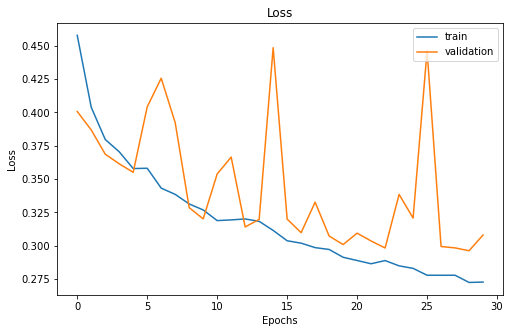

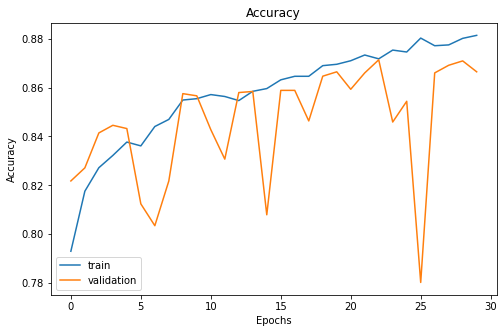

In [40]:
# Visualize the modeling results:
visualize_modeling_results(model1_vgg16_history)

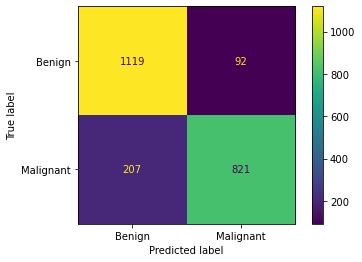

In [41]:
# Plot confusion matrix:
model1_vgg16_predictions = (model1_vgg16.predict(val_images) > 0.5).astype("int32")
model1_vgg16_cm = confusion_matrix(val_labels, model1_vgg16_predictions)
model1_vgg16_disp = ConfusionMatrixDisplay(confusion_matrix=model1_vgg16_cm, display_labels=['Benign', 'Malignant'])
model1_vgg16_disp.plot()
plt.show()

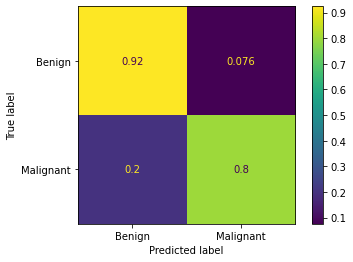

In [42]:
# Plot confusion matrix with percentages:
model1_vgg16_predictions = (model1_vgg16.predict(val_images) > 0.5).astype("int32")
model1_vgg16_cm = confusion_matrix(val_labels, model1_vgg16_predictions, normalize='true')
model1_vgg16_disp = ConfusionMatrixDisplay(confusion_matrix=model1_vgg16_cm, display_labels=['Benign', 'Malignant'])
model1_vgg16_disp.plot()
plt.show()

In [43]:
# Evaluate train and validation set:
model1_vgg16_results_train = model1_vgg16.evaluate(train_images, train_labels)
model1_vgg16_results_validation = model1_vgg16.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
model1_vgg16_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    model1_vgg16_results[model1_vgg16_results.columns[i]]['Train'] = model1_vgg16_results_train[i]
    model1_vgg16_results[model1_vgg16_results.columns[i]]['Validation'] = model1_vgg16_results_validation[i]
    
model1_vgg16_results

70/70 [==============================] - 55s 790ms/step - loss: 0.3081 - accuracy: 0.8665 - recall: 0.7986 - precision: 0.8992 - auc: 0.9424


,Loss,Accuracy,Recall,Precision,AUC
Train,0.257814,0.8873,0.820837,0.925103,0.960289
Validation,0.308099,0.866458,0.798638,0.899233,0.942421


In [60]:
# Save the model results
model1_vgg16_results.to_csv('../Saved_Models/model1_vgg16_results.csv', index=False)

In [61]:
# Save the model
model1_vgg16.save('../Saved_Models/model1_vgg16_final.h5')
print("Saved model to disk")

Saved model to disk


**Analysis:** This VGG16 model got 88% accuracy for training set and 86% accuracy for validation set. Also recall scores are not very good, 82% for training set and 79% for validation set. I will try another VGG16 model with more complex dense layers.

### Second Iteration

In [47]:
# Defined pretrained VGG-16 model:
vgg16 = VGG16(weights='imagenet',
               include_top=False,
               input_shape=(64, 64, 3))

In [48]:
# Create architecture of the model:
model2_vgg16 = models.Sequential()
model2_vgg16.add(vgg16)

# adding more dense layers of CNN iterations from final model:
model2_vgg16.add(layers.Flatten())

model2_vgg16.add(Dense(32, activation='relu', kernel_regularizer=l2(l2=0.001)))
model2_vgg16.add(BatchNormalization())

model2_vgg16.add(Dense(64, activation='relu', kernel_regularizer=l2(l2=0.001)))
model2_vgg16.add(BatchNormalization())

model2_vgg16.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.001)))
model2_vgg16.add(BatchNormalization())

model2_vgg16.add(Dense(128, activation='relu', kernel_regularizer=l2(l2=0.001)))
model2_vgg16.add(layers.Dense(1, activation='sigmoid'))

In [49]:
model2_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                65568     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [50]:
# Make sure that the pretrianed layers are untrainable
vgg16.trainable = False

In [51]:
# Print out the layers' trainability condition:
for layer in model2_vgg16.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_3 True
dense_10 True
batch_normalization True
dense_11 True
batch_normalization_1 True
dense_12 True
batch_normalization_2 True
dense_13 True
dense_14 True


In [52]:
# Define early stop criteria for model:
early_stop2 = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
    ModelCheckpoint(filepath='../Saved_Models/model2_vgg16_best_model.h5', monitor='val_accuracy', 
                    mode='max', save_best_only=True, verbose=1)]


In [53]:
# Compile and fit the model:
model2_vgg16.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

model2_vgg16_history = model2_vgg16.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    callbacks = early_stop2,
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.8227 - recall: 0.8006 - precision: 0.8107 - auc: 0.9018
Epoch 00001: val_accuracy improved from -inf to 0.84725, saving model to ../Saved_Models\model2_vgg16_best_model.h5
280/280 [==============================] - 214s 763ms/step - loss: 0.7101 - accuracy: 0.8227 - recall: 0.8006 - precision: 0.8107 - auc: 0.9018 - val_loss: 0.6848 - val_accuracy: 0.8473 - val_recall: 0.7802 - val_precision: 0.8736 - val_auc: 0.9249
Epoch 2/30
280/280 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.8555 - recall: 0.8247 - precision: 0.8551 - auc: 0.9337
Epoch 00002: val_accuracy did not improve from 0.84725
280/280 [==============================] - 275s 982ms/step - loss: 0.6385 - accuracy: 0.8555 - recall: 0.8247 - precision: 0.8551 - auc: 0.9337 - val_loss: 0.6723 - val_accuracy: 0.8267 - val_recall: 0.9115 - val_precision: 0.7593 - val_auc: 0.9337
Epoch 3/30
280/280 [=================

Epoch 19/30
280/280 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.9285 - recall: 0.9068 - precision: 0.9355 - auc: 0.9809
Epoch 00019: val_accuracy did not improve from 0.87539
280/280 [==============================] - 203s 723ms/step - loss: 0.4403 - accuracy: 0.9285 - recall: 0.9068 - precision: 0.9355 - auc: 0.9809 - val_loss: 0.6057 - val_accuracy: 0.8714 - val_recall: 0.7743 - val_precision: 0.9343 - val_auc: 0.9390
Epoch 20/30
280/280 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.9280 - recall: 0.9104 - precision: 0.9310 - auc: 0.9803
Epoch 00020: val_accuracy did not improve from 0.87539
280/280 [==============================] - 219s 781ms/step - loss: 0.4393 - accuracy: 0.9280 - recall: 0.9104 - precision: 0.9310 - auc: 0.9803 - val_loss: 0.6024 - val_accuracy: 0.8593 - val_recall: 0.7714 - val_precision: 0.9084 - val_auc: 0.9310
Epoch 21/30
280/280 [==============================] - ETA: 0s - loss: 0.4330 - accuracy: 0.9284

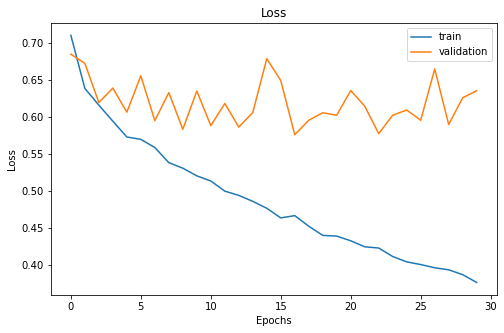

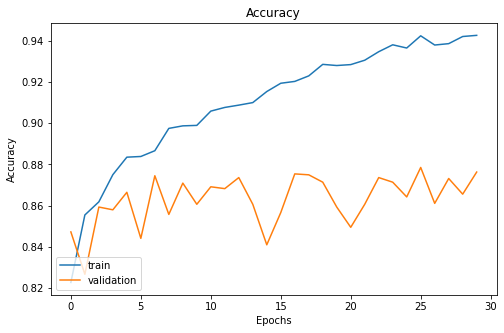

In [54]:
# Visualize the modeling results:
visualize_modeling_results(model2_vgg16_history)

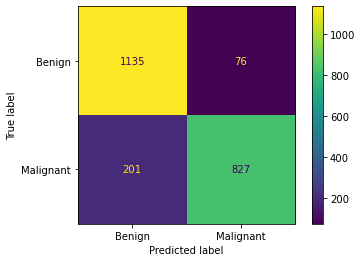

In [55]:
# Plot confusion matrix:
model2_vgg16_predictions = (model2_vgg16.predict(val_images) > 0.5).astype("int32")
model2_vgg16_cm = confusion_matrix(val_labels, model2_vgg16_predictions)
model2_vgg16_disp = ConfusionMatrixDisplay(confusion_matrix=model2_vgg16_cm, display_labels=['Benign', 'Malignant'])
model2_vgg16_disp.plot()
plt.show()

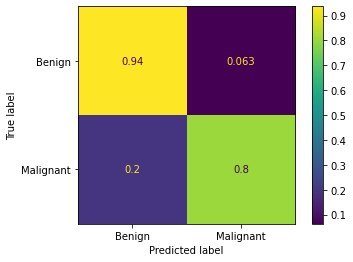

In [56]:
# Plot confusion matrix with percentages:
model2_vgg16_predictions = (model2_vgg16.predict(val_images) > 0.5).astype("int32")
model2_vgg16_cm = confusion_matrix(val_labels, model2_vgg16_predictions, normalize='true')
model2_vgg16_disp = ConfusionMatrixDisplay(confusion_matrix=model2_vgg16_cm, display_labels=['Benign', 'Malignant'])
model2_vgg16_disp.plot()
plt.show()

In [57]:
# Evaluate train and validation set:
model2_vgg16_results_train = model2_vgg16.evaluate(train_images, train_labels)
model2_vgg16_results_validation = model2_vgg16.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
model2_vgg16_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    model2_vgg16_results[model2_vgg16_results.columns[i]]['Train'] = model2_vgg16_results_train[i]
    model2_vgg16_results[model2_vgg16_results.columns[i]]['Validation'] = model2_vgg16_results_validation[i]
    
model2_vgg16_results

70/70 [==============================] - 52s 737ms/step - loss: 0.6354 - accuracy: 0.8763 - recall: 0.8045 - precision: 0.9158 - auc: 0.9385


,Loss,Accuracy,Recall,Precision,AUC
Train,0.376575,0.943594,0.895326,0.980016,0.990943
Validation,0.635351,0.876284,0.804475,0.915836,0.938486


In [58]:
# Save the model results
model2_vgg16_results.to_csv('../Saved_Models/model2_vgg16_results.csv', index=False)

In [59]:
# Save the model
model2_vgg16.save('../Saved_Models/model2_vgg16_final.h5')
print("Saved model to disk")

Saved model to disk


### Final VGG16 Model:

In [62]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load best model so far:
final_vgg16_model = load_model('../Saved_Models/model2_vgg16_final.h5')

In [63]:
final_vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                65568     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [64]:
# Test/Holdout set scores:
score = final_vgg16_model.evaluate(test_images, test_labels)

39/39 [==============================] - 14s 367ms/step - loss: 0.5455 - accuracy: 0.8891 - recall: 0.8182 - precision: 0.9221 - auc: 0.9585


In [65]:
print("%s: %.2f%%" % (final_vgg16_model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (final_vgg16_model.metrics_names[2], score[2]*100))

accuracy: 88.91%
recall: 81.82%
